In [3]:
# Import dependencies
import pandas as pd
import datetime
import time
#from sqlalchemy import create_engine
#from config import db_password

# Read in files
df = pd.read_csv('/content/btc_data.csv')

# Display initial data
df.head(10)

# keep timestamp, high, low, weighted_price
df = df[['Timestamp', 'High', 'Low', 'Volume_(BTC)', 'Weighted_Price']].reset_index(drop=True)

# preprocessing notes-- consider omitting data prior to Jan 1st, 2012 due to higher volatility 
# earlier in bitcoin's lifecycle

# converting Timestamp column to str datatype
df['str_timestamp'] = [str(timestamp) for timestamp in df['Timestamp']]
df['int_timestamp'] = df['str_timestamp'].astype('int32', copy=True)

# filtering df to only include rows after 01/01/2012
df_cleaned_filtered = df.loc[df['int_timestamp'] >= 1325391360]
df_cleaned_filtered.head(2)

# context manager to suppress 1 time SettingWithCopyWarning; alternatively call .loc after timestamp conversion to avoid error
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    df_cleaned_filtered['UTC_time'] = df_cleaned_filtered['int_timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

# dropping all null values, followed by evaluation of which time periods had the greatest data loss
final_df = df_cleaned_filtered.dropna().reset_index(drop=True)

# finding percentage of data loss (null values)
btotalLength = (len(df_cleaned_filtered))
bpartialLength = (len(final_df))
bValuesDropped = btotalLength - bpartialLength
bitstampDiff = (btotalLength - bpartialLength) / btotalLength * 100 
totalDays = round(btotalLength/1440,2)
daysDropped = round(bValuesDropped/1440,2)

print(f"Percentage of total Bitstamp data lost due to dropping rows with NaN values: {bitstampDiff:.2f}%")
print(f"Ratio of Bitstamp rows dropped: {bValuesDropped:,}/{btotalLength:,}")
print(f"Total dataset contains {totalDays} days worth of data. Due to data loss, we had to drop {daysDropped} days worth of data")

# Machine learning section
# possible implementation ideas:
# 1. time series forecasting bitcoin price with ARIMA(Auto Regressive Integrated Moving Average)
# Rational for using time series: the 4 components of time series are trends, seasonality (consistent trends that span 1 calender year), noise/irregularity, and cyclicity(trends that can be observed in <1 or >1 year); this is perfect for tradeable assets 
# Qualifying criteria: the dataset must be stationary in order to more accurately fit a time series model. Stationary means that there should be a constant mean with constant std deviation or variance
# We can test if a time series is stationary by plotting the moving avg and/or movning std dev. to see if it changes over time. These results can be supported with an ADCF test
# if testing reveals our time series is NOT stationary, we can perform a variety of transformations to change it (log transform, sq rt, exponential decay etc..)
# SARIMA is ARIMA with a seasonality component. 


# ### PGAdmin SQL Schema
# db schema thoughts: can create multiple tables for each currency (1 for btc, 1 ethereum, 1 xrp)
# can also add in additional tables down the line to support our analysis (table with google analytics, table with twitter search results for sentiment analysis)

final_df.head(5)

# Rename columns to be sql friendly
final_df.rename({'Timestamp':'timestamp',
                  'High':'high',
                  'Low':'low',
                  'Volume_(BTC)':'volume',
                  'Weighted_Price':'weightedPrice',
                  'str_timestamp':'timestampSTR',
                  'int_timestamp':'timestampINT',
                  'UTC_time':'timeUTC',
                  'time_delta':'timeDelta'
                 }, axis='columns', inplace=True)


# Checking datatypes
print(final_df.dtypes)
final_df

Percentage of total Bitstamp data lost due to dropping rows with NaN values: 27.14%
Ratio of Bitstamp rows dropped: 1,240,496/4,571,033
Total dataset contains 3174.33 days worth of data. Due to data loss, we had to drop 861.46 days worth of data
timestamp                 int64
high                    float64
low                     float64
volume                  float64
weightedPrice           float64
timestampSTR             object
timestampINT              int32
timeUTC          datetime64[ns]
dtype: object


,timestamp,high,low,volume,weightedPrice,timestampSTR,timestampINT,timeUTC
0,1325391360,4.58,4.58,1.502000,4.580000,1325391360,1325391360,2012-01-01 04:16:00
1,1325431680,4.84,4.84,10.000000,4.840000,1325431680,1325431680,2012-01-01 15:28:00
2,1325457900,5.00,5.00,10.100000,5.000000,1325457900,1325457900,2012-01-01 22:45:00
3,1325534640,5.00,5.00,19.048000,5.000000,1325534640,1325534640,2012-01-02 20:04:00
4,1325591100,5.32,5.32,2.419173,5.320000,1325591100,1325591100,2012-01-03 11:45:00
...,...,...,...,...,...,...,...,...
3330532,1600041360,10325.89,10324.35,0.081143,10324.419779,1600041360,1600041360,2020-09-13 23:56:00
3330533,1600041420,10331.97,10326.68,0.572817,10331.444396,1600041420,1600041420,2020-09-13 23:57:00
3330534,1600041480,10331.47,10321.33,2.489909,10326.175283,1600041480,1600041480,2020-09-13 23:58:00
3330535,1600041540,10334.78,10328.64,4.572660,10333.972651,1600041540,1600041540,2020-09-13 23:59:00


In [4]:
# grouping input df based on days (aggregates minute/hourly timestamps into daily)
print(len(final_df))
final_df['normalised_date'] = final_df['timeUTC'].dt.normalize()
final_df.head()
print(len(final_df))

final_df['date_only'] = final_df['normalised_date']
aggregated_df = final_df.groupby(final_df.normalised_date.dt.date).mean()
print(len(aggregated_df))
print(aggregated_df.columns)
aggregated_df

3330537
3330537
3177
Index(['timestamp', 'high', 'low', 'volume', 'weightedPrice', 'timestampINT'], dtype='object')


,timestamp,high,low,volume,weightedPrice,timestampINT
normalised_date,,,,,,
2012-01-01,1.325427e+09,4.806667,4.806667,7.200667,4.806667,1.325427e+09
2012-01-02,1.325535e+09,5.000000,5.000000,19.048000,5.000000,1.325535e+09
2012-01-03,1.325605e+09,5.252500,5.252500,11.004660,5.252500,1.325605e+09
2012-01-04,1.325682e+09,5.223333,5.200000,11.914807,5.208159,1.325682e+09
2012-01-05,1.325771e+09,6.286190,6.281429,4.514373,6.284127,1.325771e+09
...,...,...,...,...,...,...
2020-09-10,1.599739e+09,10343.558552,10334.291588,7.119214,10339.359896,1.599739e+09
2020-09-11,1.599826e+09,10306.071361,10299.283936,3.660672,10303.242947,1.599826e+09
2020-09-12,1.599912e+09,10375.469839,10370.388713,1.754713,10373.259995,1.599912e+09


In [6]:
 # importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima import auto_arima as AA
import warnings
import os
#from statsmodels.tsa.statespace.sarimax import SARIMAX
import regex as re


y = aggregated_df[['weightedPrice']]
y

,weightedPrice
normalised_date,
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159
2012-01-05,6.284127
...,...
2020-09-10,10339.359896
2020-09-11,10303.242947
2020-09-12,10373.259995


Dickey–Fuller test: p=0.6483033855184901


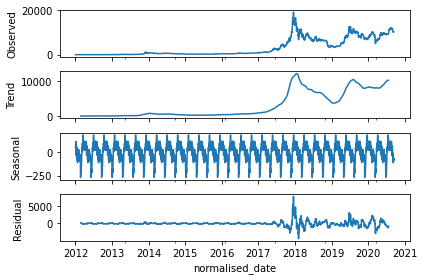

In [9]:
from statsmodels.tsa.stattools import adfuller

# time series testing requirements: since a time series is stationally, it implies the model lacks broad changes in mean/variance over time
# freq = monthyl
print(f'Dickey–Fuller test: p={adfuller(y.weightedPrice)[1]}')
seasonal_decompose(y.weightedPrice, freq=105).plot()
plt.show()

# this p-value indicates that our series is not stationary with 64.83% confidence

In [11]:
# performing Box-Cox transformation to suppress some variance
from scipy import stats

y['weighted_price_box'], lmbda = stats.boxcox(y.weightedPrice)
print(f'Dickey–Fuller test: p={adfuller(y.weighted_price_box)[1]}')

# p-value indicates data is still not stationary

Dickey–Fuller test: p=0.6566577102336565


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
print(len(y))

3177


In [18]:
# Seasonal differentiation (12 months) computing differences between observation in present year and corresponding observation in previous year 
y['box_diff_seasonal_12'] = y.weighted_price_box - y.weighted_price_box.shift(365)
print(f'Dickey–Fuller test: p={adfuller(y.box_diff_seasonal_12[365:])[1]}')

Dickey–Fuller test: p=0.22580509355719247


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
y

,weightedPrice,weighted_price_box,box_diff_seasonal_12
normalised_date,,,
2012-01-01,4.806667,1.756126,NaN
2012-01-02,5.000000,1.805402,NaN
2012-01-03,5.252500,1.867347,NaN
2012-01-04,5.208159,1.856657,NaN
2012-01-05,6.284127,2.096466,NaN
...,...,...,...
2020-09-10,10339.359896,18.928328,0.098552
2020-09-11,10303.242947,18.915549,0.029693
2020-09-12,10373.259995,18.940287,0.020006


In [35]:
# y.drop(labels=['box_diff_seasonal_12','weighted_price_box'], inplace=True, axis=1)
# augmented DF test
import statsmodels.tsa.stattools as sm

adf_test = sm.adfuller(y.weightedPrice)

In [37]:
output = pd.Series(adf_test[0:4], index=['t-statistic','p-value','lags','# observations'])
for key,value in adf_test[4].items():
  output[f'Critical value {key}'] = value
print(output)

# based on our analysis, our calculated t-statistic shows that our data is not stationary since it is greater than the critical values at all levels (greater than p value of 0.10)

t-statistic             -1.257683
p-value                  0.648303
lags                    29.000000
# observations        3147.000000
Critical value 1%       -3.432430
Critical value 5%       -2.862459
Critical value 10%      -2.567259
dtype: float64


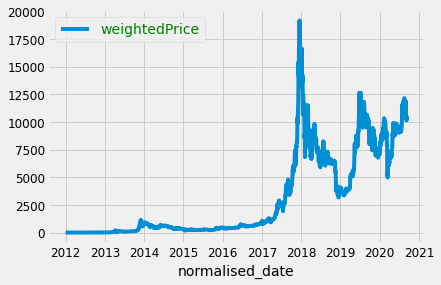

In [39]:
# importing and setting dependencies
import matplotlib
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

y.plot()

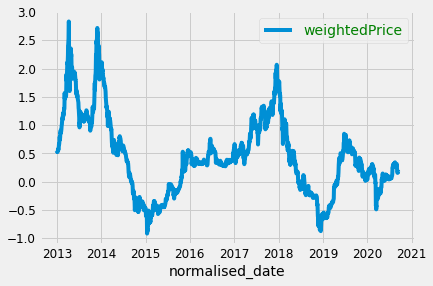

In [46]:
# applying log transformation to make data more stationary
log_data = np.log(y)
ma_data = log_data.rolling(window=365).mean() # calculating the moving average
log_minus_ma_data = log_data - ma_data
log_minus_ma_data.dropna(inplace=True)
log_minus_ma_data.plot()

In [47]:
# reapplying adf test after log transforming input data
adf_test = sm.adfuller(log_minus_ma_data.weightedPrice)
output = pd.Series(adf_test[0:4], index=['t-statistic','p-value','lags','# observations'])
for key,value in adf_test[4].items():
  output[f'Critical value {key}'] = value
print(output)

t-statistic             -2.338379
p-value                  0.159888
lags                    20.000000
# observations        2792.000000
Critical value 1%       -3.432694
Critical value 5%       -2.862576
Critical value 10%      -2.567321
dtype: float64


In [ ]:
# performing Phillips-Perron test to test if data is stationary
import pmdarima

test = pmdarima.arima.PPTest() # default alpha = 0.05
test.should_diff(log_minus_ma_data)